## Seizure freedom
Calculate predicted seizure freedom and plot for subjects

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression,RidgeClassifier, SGDClassifier
import pool.regression_functions as rf
import pool.paths as paths
import os
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import ptitprince as pt
import matplotlib
import nibabel as nb
import pool.matplotlib_surface_plotting as msp


In [4]:
lesion_file = os.path.join(paths.data_dir,'lesions.npz')


In [6]:
lesions,demographics,cortex, features = rf.prepare_data(features=[
   'Duration',
                                                                  'Age at preoperative',
                   #                                               'Lesion area',
    'Lobe',
        'Ever reported MRI negative',

                                                                  'Histology',
                                                                  'Seizure free'],
                                                        lesions_file = lesion_file,
                                                       one_hot =False)



In [7]:
#reassign lobes if cingulate and insula
lobes_i,_,lobes_labels = nb.freesurfer.read_annot(os.path.join(paths.BASE_PATH,'fsaverage_sym/label/lh.lobes.annot'))

subs_to_replace=np.where(np.logical_or(demographics[:,list(features).index('Lobe')] =='cingulate',
                            demographics[:,list(features).index('Lobe')] =='insula'))[0]
for sub in subs_to_replace:
    lesion = lesions[sub]
    
    locations=np.unique(lobes_i[lesion.astype(bool)],return_counts=True)
    k=1
    lobe='cingulate'
    print(sub)
    while lobe in ['cingulate','insula']:
        lobe=lobes_labels[locations[0][np.argsort(locations[1])[-k]]].decode()
        demographics[sub,list(features).index('Lobe')]=str(lobe)
        k+=1
        print(lobe)

In [9]:
# organise demographic features

demographics = pd.DataFrame(demographics,columns=features)
demographics=demographics.astype({'Duration':'float16','Seizure free':'int32',
                                 'Age at preoperative':'float16',
                                 'Ever reported MRI negative':'int32'})

In [10]:
#organise and normalise features
labelled=pd.get_dummies(demographics)
y=labelled['Seizure free']
x= labelled.loc[:,labelled.columns!='Seizure free']
#x=np.hstack([x,lesions[:,small_c].astype(int)])
x=pd.DataFrame(x)
durminmax = np.min(x['Duration']),np.max(x['Duration'])
ageminmax = np.min(x['Age at preoperative']),np.max(x['Age at preoperative'])
x['Duration']=(x['Duration']-np.min(x['Duration']))/(np.max(x['Duration'])-np.min(x['Duration']))
x['Age at preoperative']=(x['Age at preoperative']-np.min(x['Age at preoperative']))/(np.max(x['Age at preoperative'])-np.min(x['Age at preoperative']))


## Run logistic regression

In [21]:
clf = LogisticRegression(solver='liblinear')

clf.fit(x,y)
actual_coefs=clf.coef_.ravel()
predictions=clf.predict_proba(x)[:,1]
#recalculate coefficients on permuted cohorts for stats
permutations =1000
perm_coefs = np.zeros((permutations,len(actual_coefs)))
inds=np.arange(len(y))
for permutation in np.arange(permutations):
    np.random.shuffle(inds)
    clf.fit(x.loc[inds],y)
    perm_coefs[permutation] = clf.coef_[0].ravel()
clf.fit(x,y);


In [25]:
# 1 actual regression coefs 
# 0 pvalues
x=x.rename(columns={0:'Duration'})
pvals=0.5-np.abs(0.5-np.mean(actual_coefs>perm_coefs ,axis=0))
pd.DataFrame([actual_coefs,pvals], columns=x.columns)

,Duration,Age at preoperative,Ever reported MRI negative,Lobe_frontal,Lobe_occipital,Lobe_parietal,Lobe_temporal,Histology_FCD_1,Histology_FCD_2A,Histology_FCD_2B,Histology_FCD_3
0,-0.738508,0.033145,-0.094373,0.158616,-0.467658,0.337843,0.469672,-0.073895,0.339946,0.282266,-0.049843
1,0.030000,0.496000,0.338000,0.426000,0.048000,0.207000,0.079000,0.259000,0.178000,0.233000,0.348000


In [26]:
#Rename histology columns
histologies=[]
for c in x.columns.values:
    if 'Histo' in c:
        histologies.append(c)
histologies_n=np.zeros(len(histologies),dtype='object')
for k,histo in enumerate(histologies):
    histologies_n[k]=' '.join(histo[10:].split('_'))
histologies_n = np.array(['FCD I','FCD IIA','FCD IIB','FCD III'])

## Create prediction plots

In [27]:
#Line for 'average patient'
mean_sub=[]
hist = []
dur=[]
for k,histo in enumerate(histologies):
    m = x.median() #[x[histo]==1])
    hist_df = pd.DataFrame(np.repeat(m.values.reshape(-1,1),51,axis=1).T)
    hist_df.columns = x.columns
    hist_df['Duration']=np.linspace(0,1,51)
    hist_df['Age at preoperative']=np.linspace(0,1,51)
    mean_sub.append(clf.predict_proba(hist_df)[:,1])
    dur.append(np.linspace(0,1,51))
    hist.extend([histologies_n[k]]*51)

In [28]:
#Organise into dataframe
preds = np.hstack(mean_sub)*100
dur = np.hstack(dur)
pdf = pd.DataFrame(np.array([hist,list(preds),dur]).T,columns=['Histology','Predictions','Duration'])

In [29]:
pdf=pdf.astype({'Duration':'float16','Predictions':'float16',}
                                 )

In [30]:
#rescale durations that had previously been normalised
pdf['Duration'] = (pdf['Duration']*(durminmax[1]-durminmax[0]))+durminmax[0]
x['Duration'] = (x['Duration']*(durminmax[1]-durminmax[0]))+durminmax[0]

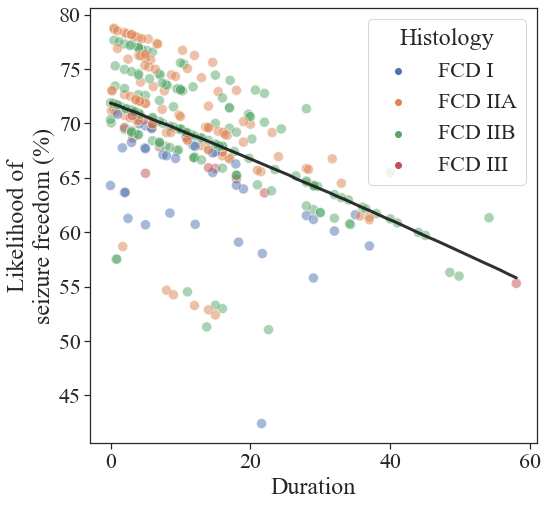

In [31]:
#Create plot
x['Predictions'] = predictions*100
x['Histology'] = histologies_n[np.argmax(x[histologies].values,axis=1)]
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 50}

#sns.set_theme(style="ticks")
matplotlib.rc('font', **font)

#plt.rcParams['legend.title_fontsize'] = 30
sns.set(rc={'figure.figsize':(8,8)}, font_scale=2)

#
sns.set_style('ticks',{'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})
sns.scatterplot(x='Duration',y='Predictions',hue='Histology',data=x,
          hue_order = histologies_n, ci=None, alpha=0.5,s=100,
                   )
sns.lineplot(x='Duration',y='Predictions',data=pdf,color='k',
          hue_order = histologies_n, ci=None, alpha=0.9,linewidth=3, legend=False)

plt.ylabel('Likelihood of\nseizure freedom (%)')
#plt.ylim([20,100])
plt.savefig(os.path.join(paths.fig_dir,'Existing_predictors.pdf'),bbox_inches='tight')